In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [4]:
def liquidity_adjusted_smart_money(df, window=60):
    """
    基于流动性的聪明钱因子
    - 使用成交量/价格波动作为流动性指标，调整聪明钱效应
    """
    close = df['close']
    taker_volume = df['taker_buy_volume']
    volume = df['volume']
    
    # 流动性指标：成交量与价格波动范围的比值
    price_range = df['high'] - df['low']
    liquidity = volume / (price_range + 1e-12)
    
    price_diff = close.diff()
    taker_ratio = taker_volume / volume.replace(0, 1e-12)
    
    gain = (price_diff * taker_ratio).where(price_diff > 0, 0)
    loss = (-price_diff * (1 - taker_ratio)).where(price_diff < 0, 0)
    
    sum_gain = gain.rolling(window).sum()
    sum_loss = loss.rolling(window).sum()
    
    # 流动性调整：避免除以零
    liquidity_avg = liquidity.rolling(window).mean() + 1e-12
    factor = (sum_gain - sum_loss) / liquidity_avg
    
    return factor

# 因子测试

In [5]:
evaluator.set_factor(
    factor_func=liquidity_adjusted_smart_money,
    factor_name='liquidity_adjusted_smart_money'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.000453
   Rank_IC (Spearman): -0.025893
📊 信息比率:
   IR: 0.746823
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130881
   因子列: liquidity_adjusted_smart_money
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


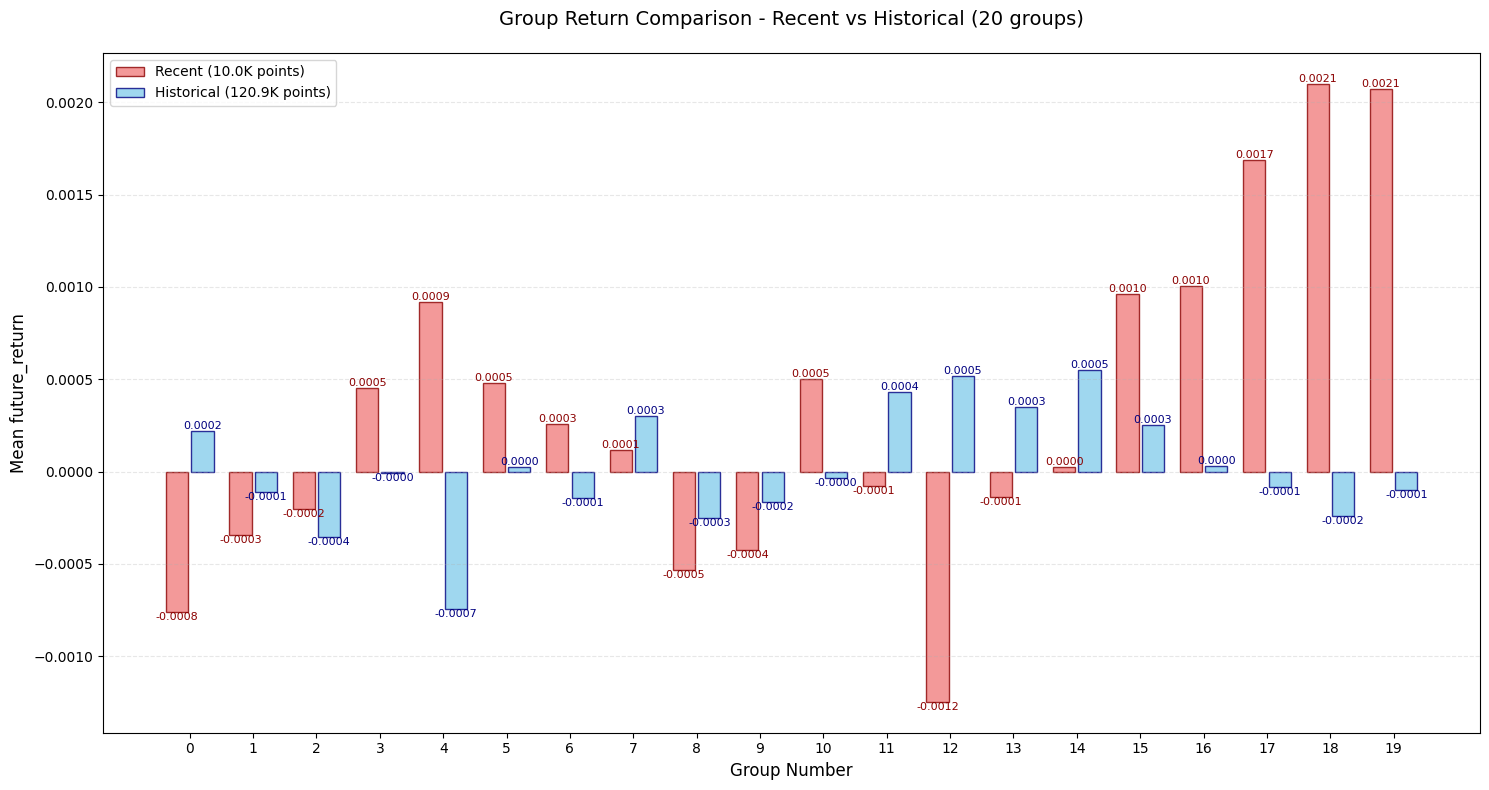

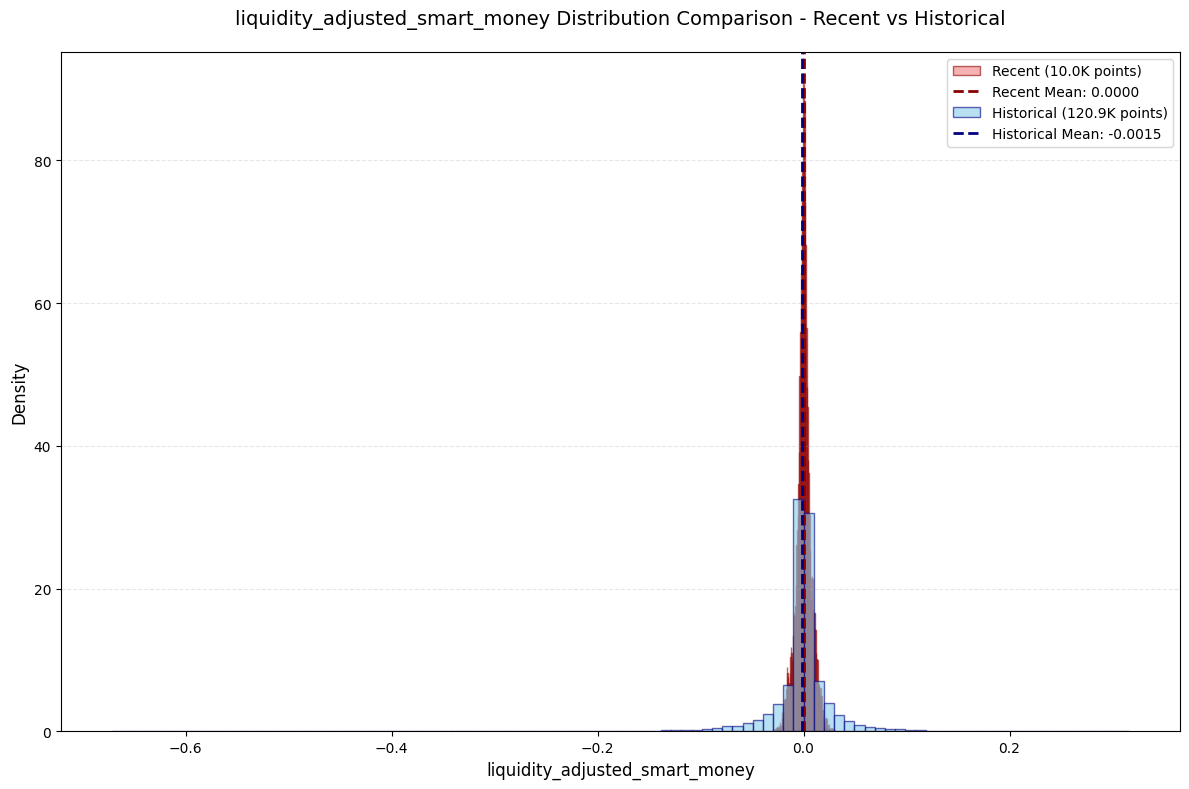

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [6]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [7]:
print(result)

{'correlation_analysis': {'IC': 0.00045260716891208847, 'Rank_IC': -0.025893405548624494}, 'information_ratio': {'IR': 0.7468226525359923, 'group_correlations': [-0.009209882787792098, 0.010612546386993507, 0.021492738879781887, 0.00973478430006263, 0.0033239877266709314, 0.029404606981699097, 0.0020215292918885387, -0.0019298394300501526, -0.00015666159125313133, 0.02082192706095471], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0      -0.6717  -0.0464   -0.0914       0.0002      0.0176   6545
1      -0.0464  -0.0243   -0.0335      -0.0001      0.0137   6544
2      -0.0243  -0.0141   -0.0187      -0.0004      0.0129   6544
3      -0.0141  -0.0084   -0.0110      -0.0001      0.0127   6544
4      -0.0084  -0.0053   -0.0067      -0.0007      0.0126   6544
5      -0.0053  -0.0034   -0.0042       0.0001      0.0113   6544
6      -0.0034  -0.0021   -0.002